# Lesson 10: Final Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/master/notebooks/10_Final_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Wiener First Passage of Time
- More discussion of PDA
- Extensions to LBA model
- Model comparisons


## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/master/notebooks/decision_data.csv

In [ ]:
# to retrieve the wfpt model
!wget https://raw.githubusercontent.com/compmem/QuantCog/master/notebooks/wfpt.py

## Load and process the data

In [106]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists, calc_bpic, joint_plot

from wfpt import wfpt_like, wfpt_gen

from joblib import Parallel, delayed
try:
    import scoop
    from scoop import futures
except ImportError:
    print("Error loading scoop, reverting to joblib.")
    scoop = None


Error loading scoop, reverting to joblib.


In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


## Wiener First Passage of Time (WFPT)

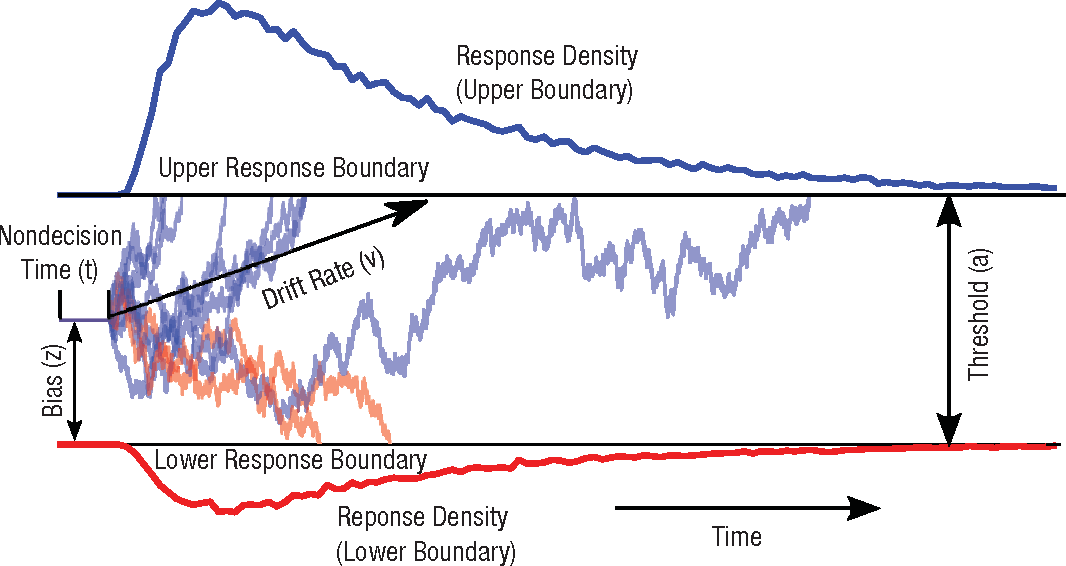


In [94]:
# set up the sim
nsims = 5000
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
def run_wfpt(cond, v_mean, a, w_mode, w_std=0.0,
             v_std=0.0, t0=0.0, nsamp=5000, err=.0001):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = wfpt_like(np.ones(len(xvals))*2, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = wfpt_like(np.ones(len(xvals))*1, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

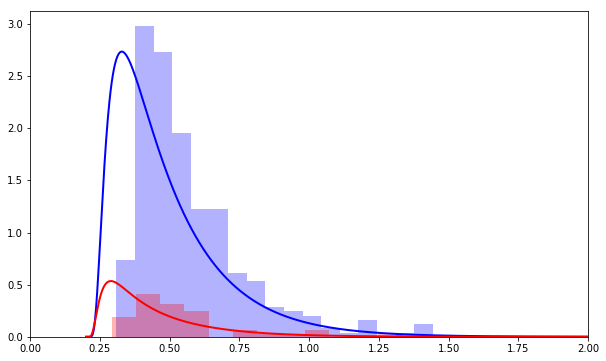

In [96]:
# set up new figure
plt.figure(figsize=(10,6))

# try different params!
cond='Accuracy'

v_mean = 1.75
v_std = 0.0
a = 1.2
w_mode = 0.45
w_std = 0.0
t0 = 0.2

# call the function
run_wfpt(cond, v_mean, a, w_mode, w_std=w_std,
         v_std=v_std, t0=t0, nsamp=2000, err=.0001)


## Using computers to test hypotheses

In [56]:
# grab the beh data of interest
choices_A = np.array(dat[(dat['cond']=='Accuracy')]['correct']+1)
rts_A = np.array(dat[(dat['cond']=='Accuracy')]['rt'])
choices_S = np.array(dat[(dat['cond']=='Speed')]['correct']+1)
rts_S = np.array(dat[(dat['cond']=='Speed')]['rt'])


In [57]:
# this is the required def for RunDEMC
def eval_fun(pop, *args):
    pnames = args[0]

    if scoop and scoop.IS_RUNNING:
        likes = list(futures.map(eval_mod, [indiv for indiv in pop],
                                 [pnames]*len(pop)))
    else:
        # use joblib
        likes = Parallel(n_jobs=-1)(delayed(eval_mod)(indiv, pnames)
                                    for indiv in pop)

    return np.array(likes)

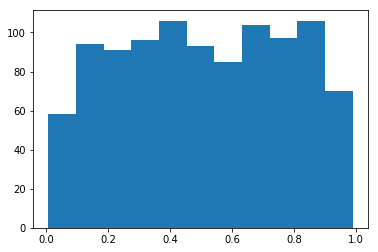

In [78]:
plt.hist(dists.invlogit(dists.normal(0, 1.4).rvs(1000)), bins='auto');

In [98]:
# Test change in threshold

# set up the params
params = [Param(name='v_A', prior=dists.normal(0., 2.)),
          Param(name='v_S', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='a_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]
param_names = [p.name for p in params]

# define the likelihood function
def eval_mod(params, param_names):
    log_like = 0.0
    p = {param_names[j]: params[j] for j in range(len(params))}
    
    # first Accuracy
    likes_A = wfpt_like(choices_A, rts_A, 
                        v_mean=p['v_A'], v_std=0.0, a=p['a_A'], 
                        w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                        nsamp=1000)
    log_like += np.log(likes_A).sum()

    # then Speed
    likes_S = wfpt_like(choices_S, rts_S, 
                        v_mean=p['v_S'], v_std=0.0, a=p['a_S'], 
                        w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                        nsamp=1000)
    log_like += np.log(likes_S).sum()

    return log_like
        
# make the model
m = Model('all', params=params,
          like_fun=eval_fun,
          like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [99]:
# do some burnin
times = m.sample(75, burnin=True)

Initializing: 60(60) 48(48) 36(36) 30(30) 21(21) 16(16) 11(11) 7(7) 7(7) 6(6) 2(2) 2(2) 2(2) 1(1) 1(1) 1(1) Iterations (75): 1 2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 


In [109]:
# sample from the posterior
times = m.sample(400, burnin=False)

Iterations (400): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 27

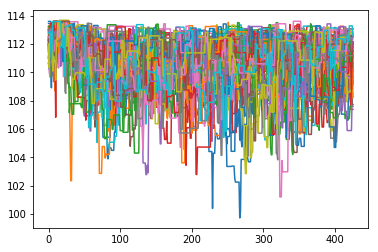

In [111]:
plt.plot(m.weights[50:]);

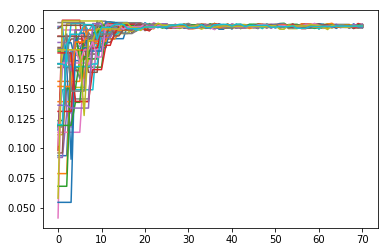

In [89]:
plt.plot(m.particles[10:, :, 3]);

In [112]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 113.68318683741231
"v_A": 2.159118,
"v_S": 1.679830,
"w": 0.354668,
"a_A": 1.637567,
"a_S": 0.904989,
"t0": 0.203202,


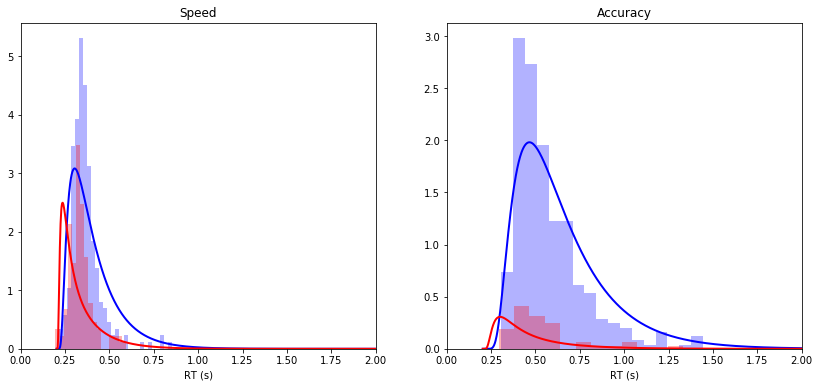

In [113]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_wfpt(cond, v_mean=pp['v_S'], a=pp['a_S'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_wfpt(cond, v_mean=pp['v_A'], a=pp['a_A'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);


## Exploring the posterior

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))


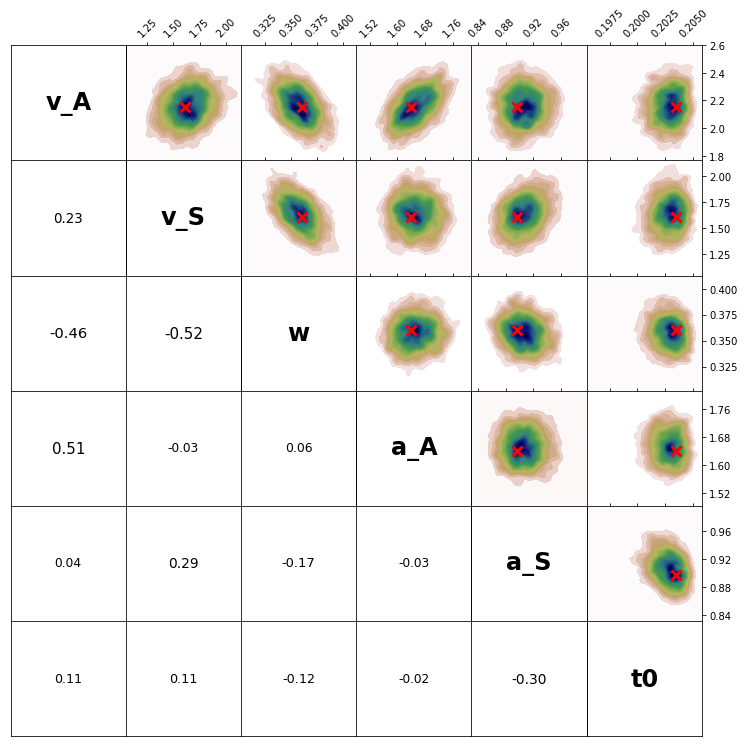

In [115]:
plt.figure(figsize=(12,12))

burnin = 250
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);